In [ ]:
import random
import time
import numpy as np
import pandas as pd
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image
import csv

# 4. Creating a dataset for training the control model

In [2]:
base_dir = "D:/programs/SelfDrive/DATA"
scene_numb = 29551

In [147]:
def path_or_nan(path):
    return path if os.path.exists(path) else None

In [148]:
df = pd.read_csv(r"D:\programs\SelfDrive\DATA\vehicle_commands.csv")

df["rgb_camera_front"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/camera_front/{x}.png"))
df["rgb_camera_left"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/camera_left/{x}.png"))
df["rgb_camera_right"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/camera_right/{x}.png"))

df["semantic_camera_front"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/semantic_camera_front/{x}.npy"))
df["semantic_camera_left"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/semantic_camera_left/{x}.npy"))
df["semantic_camera_right"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/semantic_camera_right/{x}.npy"))

df["lidar_proj_front"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/lidar_projection_front/{x}.npz"))
df["lidar_proj_left"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/lidar_projection_left/{x}.npz"))
df["lidar_proj_right"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/lidar_projection_right/{x}.npz"))

df["trajectory"] = df["frame_id"].apply(lambda x: path_or_nan(f"{base_dir}/trajectory/{x}.npy"))

lights_df = pd.read_csv(os.path.join(base_dir, "traffic_light.csv"))

In [149]:
#One-hot encoding of traffic light states
lights_df["green"]  = (lights_df["state"] == "green").astype(int)
lights_df["yellow"] = (lights_df["state"] == "yellow").astype(int)
lights_df["red"]    = (lights_df["state"] == "red").astype(int)

In [150]:
lights_df = lights_df[["frame_id", "green", "yellow", "red"]]

In [151]:
df = df.merge(lights_df, on="frame_id", how="left")

In [152]:
df[["green", "yellow", "red"]] = df[["green", "yellow", "red"]].fillna(0).astype(int)

In [153]:
target_cols = ["speed", "steer", "throttle", "brake"]
feature_cols = [col for col in df.columns if col not in target_cols]

In [154]:
df = df[feature_cols + target_cols]
df.head()

,frame_id,rgb_camera_front,rgb_camera_left,rgb_camera_right,semantic_camera_front,semantic_camera_left,semantic_camera_right,lidar_proj_front,lidar_proj_left,lidar_proj_right,trajectory,green,yellow,red,speed,steer,throttle,brake
0,6796,D:/programs/SelfDrive/DATA/camera_front/6796.png,D:/programs/SelfDrive/DATA/camera_left/6796.png,D:/programs/SelfDrive/DATA/camera_right/6796.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6796.npy,0,0,0,22.152759,-0.000010,0.75,0.0
1,6800,D:/programs/SelfDrive/DATA/camera_front/6800.png,D:/programs/SelfDrive/DATA/camera_left/6800.png,D:/programs/SelfDrive/DATA/camera_right/6800.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6800.npy,0,0,0,24.372782,0.000014,0.75,0.0
2,6804,D:/programs/SelfDrive/DATA/camera_front/6804.png,D:/programs/SelfDrive/DATA/camera_left/6804.png,D:/programs/SelfDrive/DATA/camera_right/6804.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6804.npy,0,0,0,29.317393,0.000003,0.00,0.3
3,6808,D:/programs/SelfDrive/DATA/camera_front/6808.png,D:/programs/SelfDrive/DATA/camera_left/6808.png,D:/programs/SelfDrive/DATA/camera_right/6808.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6808.npy,0,0,0,23.751873,0.000011,0.75,0.0
4,6812,D:/programs/SelfDrive/DATA/camera_front/6812.png,D:/programs/SelfDrive/DATA/camera_left/6812.png,D:/programs/SelfDrive/DATA/camera_right/6812.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6812.npy,0,0,0,22.841153,0.000005,0.75,0.0


In [165]:
len(df)

13039

In [156]:
#Saving the raw dataset
df.to_csv(os.path.join(base_dir, "collected_data.csv"), index=False)

4.1 Data analysis and preprocessing

In [157]:
df_final = pd.read_csv(os.path.join(base_dir, "collected_data.csv"))

In [158]:
#Filtering scenes with prolonged stopping (control commands = 0)
#Keep the first and last 2 scenes
mask = (df_final["speed"] == 0.0) & \
       (df_final["steer"] == 0.0) & \
       (df_final["throttle"] == 0.0) & \
       (df_final["brake"] == 0.5)

#Grouping consecutive identical values
group = (mask != mask.shift()).cumsum()
df_final["group"] = group  #temporary addition to the dataframe

#Creating a list of indices to retain
keep = []
for g, group_df in df_final.groupby("group"):
    if group_df["speed"].iloc[0] == 0.0 and group_df["steer"].iloc[0] == 0.0 and \
       group_df["throttle"].iloc[0] == 0.0 and group_df["brake"].iloc[0] == 0.5:
        
        if len(group_df) > 4:
            keep.extend(group_df.index[:2])      
            keep.extend(group_df.index[-2:])     
        else:
            keep.extend(group_df.index)          
    else:
        keep.extend(group_df.index)              

df_final = df_final.loc[keep].reset_index(drop=True)

df_final.drop(columns=["group"], inplace=True)

#Filtering scenes by speed
df_final = df_final[df_final["speed"] <= 30]

len(df_final)

5835

In [159]:
df_final[target_cols].describe()

,speed,steer,throttle,brake
count,5835.000000,5835.000000,5835.000000,5835.000000
mean,15.688956,0.039108,0.460757,0.148482
std,11.096189,0.186073,0.355490,0.211782
min,0.000000,-0.800000,0.000000,0.000000
25%,1.033374,-0.001694,0.000000,0.000000
50%,19.484439,0.000000,0.750000,0.000000
75%,25.271087,0.008178,0.750000,0.300000
max,29.997846,0.800000,0.750000,0.500000


In [160]:
df_final.isnull().sum()

frame_id                   0
rgb_camera_front         188
rgb_camera_left          149
rgb_camera_right           0
semantic_camera_front      0
semantic_camera_left       0
semantic_camera_right      0
lidar_proj_front           0
lidar_proj_left            0
lidar_proj_right           0
trajectory                37
green                      0
yellow                     0
red                        0
speed                      0
steer                      0
throttle                   0
brake                      0
dtype: int64

In [175]:
df_final = df_final.dropna().reset_index(drop=True)

In [176]:
df_final.head()

,frame_id,rgb_camera_front,rgb_camera_left,rgb_camera_right,semantic_camera_front,semantic_camera_left,semantic_camera_right,lidar_proj_front,lidar_proj_left,lidar_proj_right,trajectory,green,yellow,red,speed,steer,throttle,brake
0,6796,D:/programs/SelfDrive/DATA/camera_front/6796.png,D:/programs/SelfDrive/DATA/camera_left/6796.png,D:/programs/SelfDrive/DATA/camera_right/6796.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6796.npy,0,0,0,22.152759,-0.000010,0.75,0.0
1,6800,D:/programs/SelfDrive/DATA/camera_front/6800.png,D:/programs/SelfDrive/DATA/camera_left/6800.png,D:/programs/SelfDrive/DATA/camera_right/6800.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6800.npy,0,0,0,24.372782,0.000014,0.75,0.0
2,6804,D:/programs/SelfDrive/DATA/camera_front/6804.png,D:/programs/SelfDrive/DATA/camera_left/6804.png,D:/programs/SelfDrive/DATA/camera_right/6804.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6804.npy,0,0,0,29.317393,0.000003,0.00,0.3
3,6808,D:/programs/SelfDrive/DATA/camera_front/6808.png,D:/programs/SelfDrive/DATA/camera_left/6808.png,D:/programs/SelfDrive/DATA/camera_right/6808.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6808.npy,0,0,0,23.751873,0.000011,0.75,0.0
4,6812,D:/programs/SelfDrive/DATA/camera_front/6812.png,D:/programs/SelfDrive/DATA/camera_left/6812.png,D:/programs/SelfDrive/DATA/camera_right/6812.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/6812.npy,0,0,0,22.841153,0.000005,0.75,0.0


In [184]:
len(df_final)

5616

In [183]:
#Display data for a random scene
df_final[df_final['frame_id'] == scene_numb]

,frame_id,rgb_camera_front,rgb_camera_left,rgb_camera_right,semantic_camera_front,semantic_camera_left,semantic_camera_right,lidar_proj_front,lidar_proj_left,lidar_proj_right,trajectory,green,yellow,red,speed,steer,throttle,brake
2211,29551,D:/programs/SelfDrive/DATA/camera_front/29551.png,D:/programs/SelfDrive/DATA/camera_left/29551.png,D:/programs/SelfDrive/DATA/camera_right/29551.png,D:/programs/SelfDrive/DATA/semantic_camera_fro...,D:/programs/SelfDrive/DATA/semantic_camera_lef...,D:/programs/SelfDrive/DATA/semantic_camera_rig...,D:/programs/SelfDrive/DATA/lidar_projection_fr...,D:/programs/SelfDrive/DATA/lidar_projection_le...,D:/programs/SelfDrive/DATA/lidar_projection_ri...,D:/programs/SelfDrive/DATA/trajectory/29551.npy,1,0,0,17.573919,0.000014,0.75,0.0


4.1 Data preprocessing for model training

In [168]:
#Loading and preprocessing RGB image
def process_rgb_image(path, size=(224, 224)):
    img = Image.open(path).convert("RGB")
    img = img.resize(size)
    img = np.array(img).astype(np.float32) / 255.0
    return img  #(224, 224, 3)

#Loading and preprocessing semantic mask
def process_semantic_mask(path, size=(224, 224)):
    mask = np.load(path)
    mask = cv2.resize(mask, size, interpolation=cv2.INTER_NEAREST)
    return mask.astype(np.int64)  #(224, 224)

#Loading and preprocessing LiDAR point projection (into a depth map)
def process_lidar_projection(path, size=(224, 224)):
    data = np.load(path)
    uvs = data["pixels"]  #(N, 2)
    depths = data["depths"]  #(N,)

    depth_map = np.zeros(size, dtype=np.float32)
    for (u, v), d in zip(uvs, depths):
        u, v = int(u * size[0] / 1280), int(v * size[1] / 720)
        if 0 <= u < size[0] and 0 <= v < size[1]:
            depth_map[v, u] = d  #y, x
    return depth_map  #(224, 224)

#Loading and processing trajectory
def load_trajectory_from_npy(path):
    traj = np.load(path)  #(10, 2)
    traj = traj.astype(np.float32)
    return traj

In [169]:
def load_scene(frame_id, df):
    row = df[df["frame_id"] == frame_id].iloc[0]

    rgb_front = process_rgb_image(os.path.join(base_dir, row["rgb_camera_front"]))
    rgb_left  = process_rgb_image(os.path.join(base_dir, row["rgb_camera_left"]))
    rgb_right = process_rgb_image(os.path.join(base_dir, row["rgb_camera_right"]))

    sem_front = process_semantic_mask(os.path.join(base_dir, row["semantic_camera_front"]))
    sem_left  = process_semantic_mask(os.path.join(base_dir, row["semantic_camera_left"]))
    sem_right = process_semantic_mask(os.path.join(base_dir, row["semantic_camera_right"]))

    lidar_front = process_lidar_projection(os.path.join(base_dir, row["lidar_proj_front"]))
    lidar_left  = process_lidar_projection(os.path.join(base_dir, row["lidar_proj_left"]))
    lidar_right = process_lidar_projection(os.path.join(base_dir, row["lidar_proj_right"]))

    traj = load_trajectory_from_npy(os.path.join(base_dir, row["trajectory"]))
    
    lights = {
        "green": row["green"],
        "red": row["red"],
        "yellow": row["yellow"]
    }
    
    target = {
        "speed": row["speed"],
        "steer": row["steer"],
        "throttle": row["throttle"],
        "brake": row["brake"]
    }

    return {
        "rgb": [rgb_front, rgb_left, rgb_right],
        "semantic": [sem_front, sem_left, sem_right],
        "lidar": [lidar_front, lidar_left, lidar_right],
        "trajectory": traj,
        "lights": lights,
        "target": target
    }

4.3 Preparing the dataset for model training

In [186]:
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm 

dataset = []

def process_frame(frame_id):
    try:
        return load_scene(frame_id, df_final)
    except Exception as e:
        print(f"error_frame_id={frame_id}: {e}")
        return None
    
num_threads = 12
with ThreadPoolExecutor(max_workers=num_threads) as executor:
    futures = [executor.submit(process_frame, fid) for fid in df_final["frame_id"]]
    for future in tqdm(as_completed(futures), total=len(futures)):
        result = future.result()
        if result is not None:
            dataset.append(result)

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 5616/5616 [13:03<00:00,  7.17it/s]


In [190]:
len(dataset)

5616

In [189]:
import pickle
with open("processed_dataset.pkl", "wb") as f:
    pickle.dump(dataset, f)

In [194]:
dataset_path = r"D:\programs\SelfDrive\processed_dataset.pkl"

with open(dataset_path, "rb") as f:
    dataset = pickle.load(f)

# 5. Initialization and training of the control model

5.1 Dataset for loading data from processed_dataset

In [240]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

class CarlaDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]

        #Input images
        #RGB: (3, 224, 224, 3) - (3, 3, 224, 224)
        rgb = torch.from_numpy(np.stack(scene["rgb"])).permute(0, 3, 1, 2).float()  #(3, 3, 224, 224)
        rgb = rgb.reshape(-1, 224, 224)  # → (9, 224, 224)

        #Lidar: (3, 224, 224)
        lidar = torch.from_numpy(np.stack(scene["lidar"])).float()  #(3, 224, 224)

        #Semantic: (3, 224, 224)
        semantic = torch.from_numpy(np.stack(scene["semantic"])).float()  #(3, 224, 224)

        #Concatenation: 9 + 3 + 3 = 15 
        input_tensor = torch.cat([rgb, lidar, semantic], dim=0)  #(15, 224, 224)

        #Additional features
        trajectory_tensor = torch.from_numpy(scene["trajectory"]).float()  #(10, 2)

        lights = scene["lights"]
        light_tensor = torch.tensor([
            lights["green"],
            lights["red"],
            lights["yellow"]
        ], dtype=torch.float32)  # (3,)

        #Target variables
        target = scene["target"]
        target_tensor = torch.tensor([
            target["speed"],
            target["steer"],
            target["throttle"],
            target["brake"]
        ], dtype=torch.float32)  # (4,)

        return {
            "input": input_tensor,              #(15, 224, 224)
            "trajectory": trajectory_tensor,    #(10, 2)
            "traffic_lights": light_tensor,     #(3,)
            "target": target_tensor             #(4,)
        }

In [241]:
from sklearn.model_selection import train_test_split
train_data, temp_data = train_test_split(dataset, test_size=0.3, random_state=42)

In [242]:
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

In [243]:
train_dataset = CarlaDataset(train_data)
val_dataset   = CarlaDataset(val_data)
test_dataset  = CarlaDataset(test_data)

5.2 Model, optimizer, and loss function initialization

In [265]:
class CarlaControlModel(nn.Module):
    def __init__(self):
        super().__init__()

        #CNN block for processing the input image (15 channels)
        self.conv = nn.Sequential(
            nn.Conv2d(15, 32, kernel_size=5, stride=2, padding=2),  
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1), 
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.AdaptiveAvgPool2d((1, 1)) 
        )

        self.fc_image = nn.Linear(128, 64)

        #Block for processing the planned trajectory
        self.fc_traj = nn.Sequential(
            nn.Linear(20 * 2, 32),
            nn.ReLU(),
            nn.Linear(32, 16)
        )

        #Block for processing traffic light signals
        self.fc_lights = nn.Sequential(
            nn.Linear(3, 8),
            nn.ReLU()
        )

        #Final block for predicting control commands
        self.head = nn.Sequential(
            nn.Linear(64 + 16 + 8, 64),
            nn.ReLU(),
            nn.Linear(64, 4) 
        )

    def forward(self, input_img, trajectory, traffic_lights):
        x = self.conv(input_img)  
        x = x.view(x.size(0), -1)  
        x = self.fc_image(x)      

        traj = self.fc_traj(trajectory.view(trajectory.size(0), -1)) 
        lights = self.fc_lights(traffic_lights) 

        combined = torch.cat([x, traj, lights], dim=1)  
        out = self.head(combined)  

        return out
        
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CarlaControlModel().to(device)

In [266]:
criterion = nn.MSELoss()  
optimizer = optim.Adam(model.parameters(), lr=1e-4)

5.3 Creating the DataLoaders

In [267]:
from torch.utils.data import DataLoader

In [268]:
BATCH_SIZE = 64

In [269]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

5.4 Training loop

In [ ]:
EPOCHS = 120
best_val_loss = float('inf')

train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    start_time = time.time()

    model.train()
    train_loss = 0.0

    for batch in tqdm(train_loader, desc="Training"):
        inputs = batch["input"].to(device)
        traj = batch["trajectory"].to(device)
        lights = batch["traffic_lights"].to(device)
        targets = batch["target"].to(device)

        optimizer.zero_grad()
        outputs = model(inputs, traj, lights)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = batch["input"].to(device)
            traj = batch["trajectory"].to(device)
            lights = batch["traffic_lights"].to(device)
            targets = batch["target"].to(device)

            outputs = model(inputs, traj, lights)
            loss = criterion(outputs, targets)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    elapsed = time.time() - start_time
    print(f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Time: {elapsed:.2f}s")

    #Save Best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), "best_model.pth")
        print("Model saved")

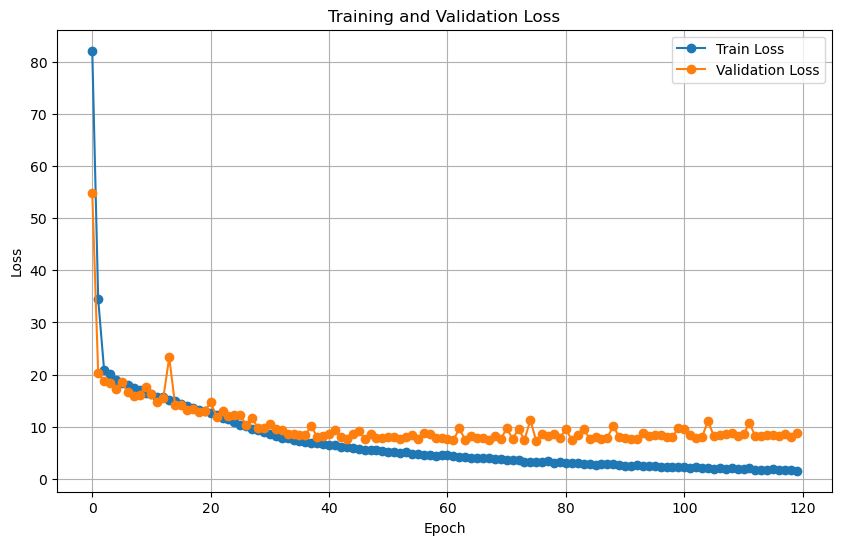

In [272]:
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss', marker='o')
plt.plot(val_losses, label='Validation Loss', marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

5.5 Final evaluation of the model

In [273]:
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

C:\Users\egork\AppData\Local\Temp\ipykernel_12912\3738422358.py:1: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



CarlaControlModel(
  (conv): Sequential(
    (0): Conv2d(15, 32, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): AdaptiveAvgPool2d(output_size=(1, 1))
  )
  (fc_image): Linear(in_features=128, out_features=64, bias=True)
  (fc_traj): Sequential(
    (0): Linear(in_features=40, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=16, bias=True)
  )
  (fc_lights): Sequential(
    (0): Linear(in_features=3, out_features=8, bias=True)
    (1): ReLU()
  )
  (head): Sequential(
    (0):

In [274]:
test_loss = 0.0
speed_loss = 0.0
steer_loss = 0.0
throttle_loss = 0.0
brake_loss = 0.0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Testing"):
        inputs = batch["input"].to(device)
        traj = batch["trajectory"].to(device)
        lights = batch["traffic_lights"].to(device)
        targets = batch["target"].to(device)

        outputs = model(inputs, traj, lights)

        loss = criterion(outputs, targets)
        test_loss += loss.item()

        #Unpacking the loss for each target variable
        diff = torch.abs(outputs - targets)
        speed_loss += diff[:, 0].mean().item()
        steer_loss += diff[:, 1].mean().item()
        throttle_loss += diff[:, 2].mean().item()
        brake_loss += diff[:, 3].mean().item()

n_batches = len(test_loader)
print(f"\nTest Loss: {test_loss / n_batches:.4f}")
print(f"Speed MAE:     {speed_loss / n_batches:.4f}")
print(f"Steer MAE:     {steer_loss / n_batches:.4f}")
print(f"Throttle MAE:  {throttle_loss / n_batches:.4f}")
print(f"Brake MAE:     {brake_loss / n_batches:.4f}")

Testing: 100%|███████████████████████████████████████████████████████████████████████████████████████████| 27/27 [00:06<00:00,  4.25it/s]


Test Loss: 6.5944
Speed MAE:     3.8075
Steer MAE:     0.0814
Throttle MAE:  0.2914
Brake MAE:     0.1477
